In [2]:
# IMPORTS

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# libraries and functions used throughout:

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error, r2_score

from sklearn.model_selection import GridSearchCV

In [5]:
# LOAD THE DATA

fn_train = 'TCGA_expression_features.csv'
train_data = pd.read_csv(fn_train)


The dataset was obtained from the Cancer Genome Atlas (TCGA) and includes clinical data for 516 head and neck squamous cell carcinoma patients (HNSCC), along with the expression levels of 136 cancer-relevant genes associated with tumour aggressiveness.

First wanted to do some exploratory analysis to look at distribution of different features, and to remove any with a lot of missing data.


In [7]:
print(train_data.describe(include = 'all'))


        cross_reference node_status gender   race               ethnicity  \
count               516         416    516    503                     502   
unique              516           2      2      5                       3   
top     TCGA-4P-AA8J-01    positive   MALE  WHITE  NOT HISPANIC OR LATINO   
freq                  1         239    376    441                     454   
mean                NaN         NaN    NaN    NaN                     NaN   
std                 NaN         NaN    NaN    NaN                     NaN   
min                 NaN         NaN    NaN    NaN                     NaN   
25%                 NaN         NaN    NaN    NaN                     NaN   
50%                 NaN         NaN    NaN    NaN                     NaN   
75%                 NaN         NaN    NaN    NaN                     NaN   
max                 NaN         NaN    NaN    NaN                     NaN   

       history_other_malignancy.x margin_status vital_status  \
count      

In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 516 entries, 0 to 515
Columns: 163 entries, cross_reference to ZNF582_147948
dtypes: float64(151), int64(1), object(11)
memory usage: 657.2+ KB


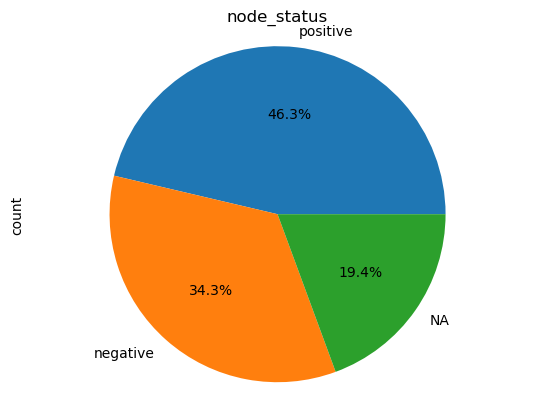

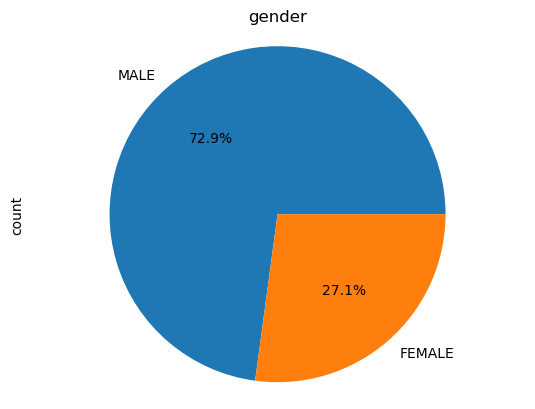

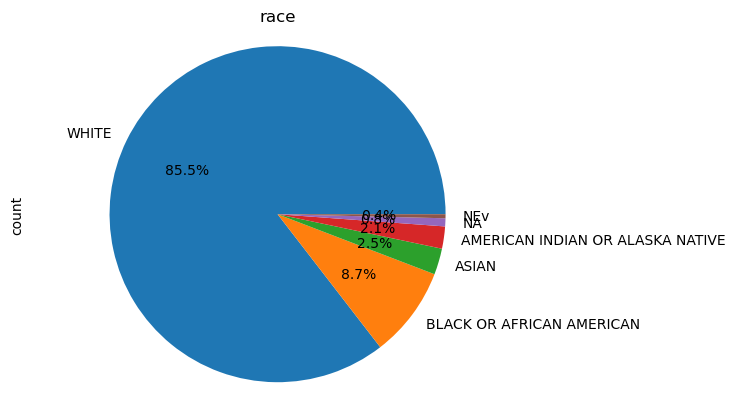

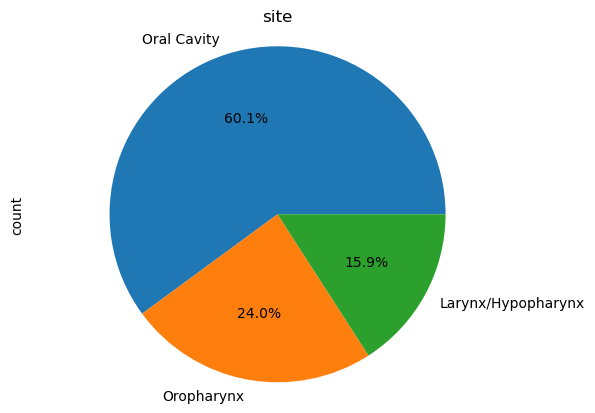

In [23]:
col ='node_status'
counts = train_data[col].value_counts(dropna=False)
counts.plot.pie(autopct='%1.1f%%', labels=['positive', 'negative', 'NA'], shadow=False)
plt.title(col)
plt.axis('equal')
plt.show()

col ='gender'
counts = train_data[col].value_counts(dropna=False)
counts.plot.pie(autopct='%1.1f%%', labels=['MALE', 'FEMALE', 'NA'], shadow=False)
plt.title(col)
plt.axis('equal')
plt.show()

col ='race'
counts = train_data[col].value_counts(dropna=False)
counts.plot.pie(autopct='%1.1f%%', labels=['WHITE', 'BLACK OR AFRICAN AMERICAN', 'ASIAN','AMERICAN INDIAN OR ALASKA NATIVE','NA','NEv'], shadow=False)
plt.title(col)
plt.axis('equal')
plt.show()

col ='site'
counts = train_data[col].value_counts(dropna=False)
counts.plot.pie(autopct='%1.1f%%', labels=['Oral Cavity', 'Oropharynx', 'Larynx/Hypopharynx'], shadow=False)
plt.title(col)
plt.axis('equal')
plt.show()

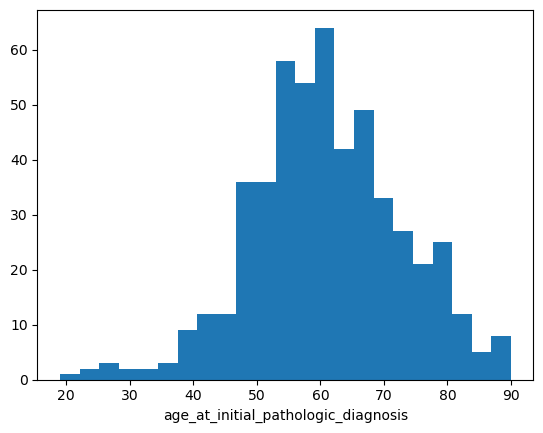

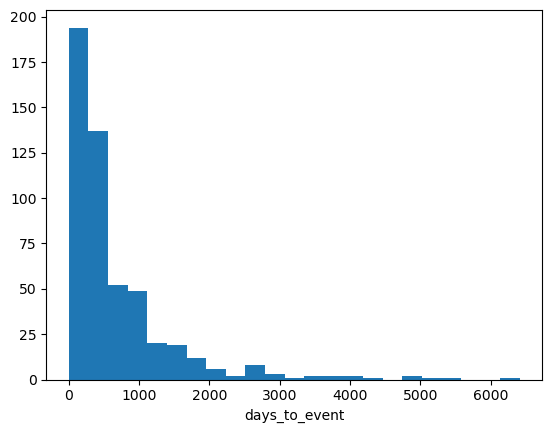

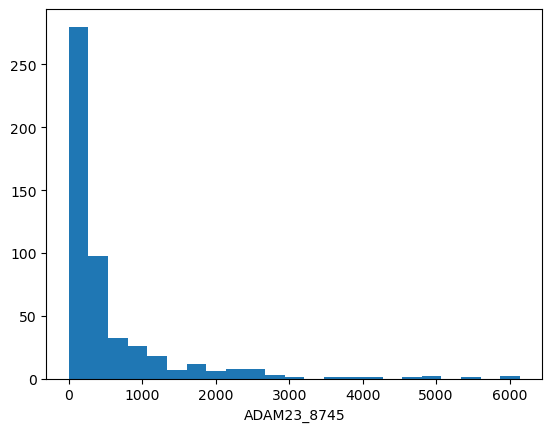

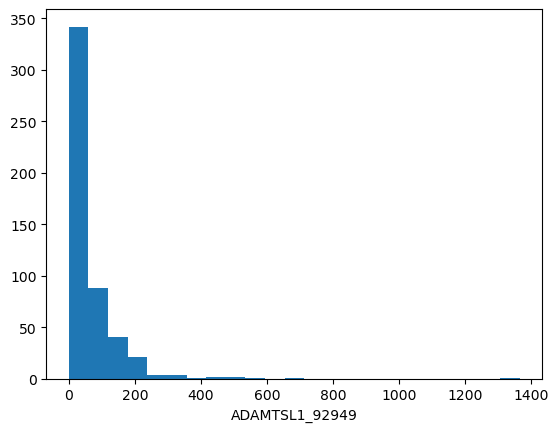

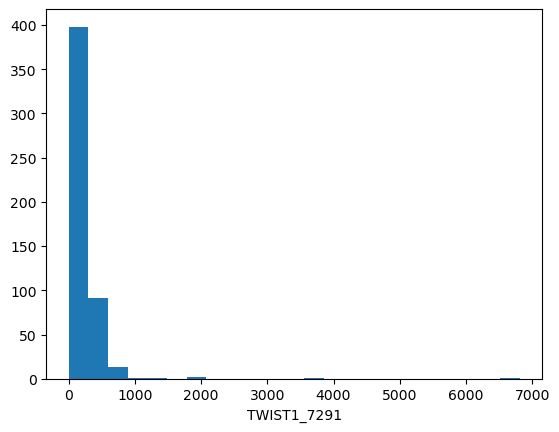

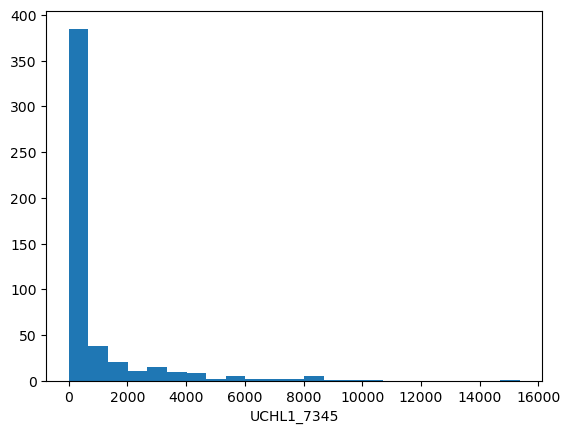

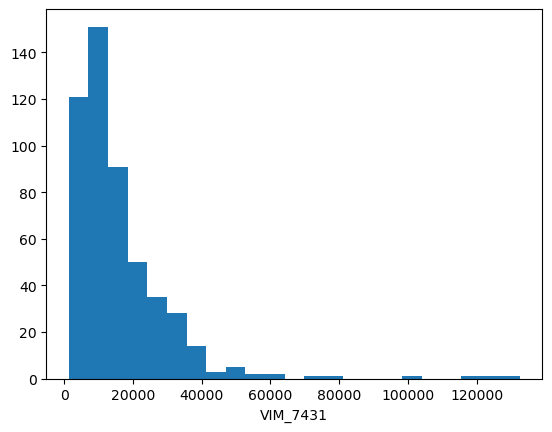

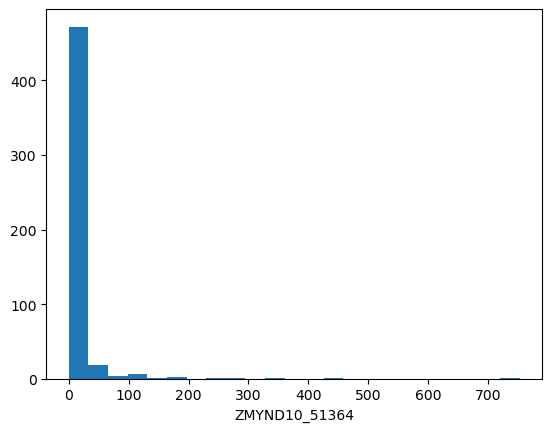

In [12]:


# general rule of thumb for number of bins in the square root of the number of datapoints
number_of_bins = 23

for col in ['age_at_initial_pathologic_diagnosis','days_to_event','ADAM23_8745','ADAMTSL1_92949','TWIST1_7291','UCHL1_7345','VIM_7431','ZMYND10_51364']:
    plt.figure()
    plt.hist(train_data[col],bins = number_of_bins)
    plt.xlabel(col)
    # plt.xscale('log') you could log scale the x axis and see what the distribution looks like
    plt.show()

In [24]:
# print each feature along with its number of NaN values

for idx,col in enumerate(train_data.isnull().sum()):
    print(train_data.columns[idx],col)
    
nan_rows = 0

# Iterate through each row (index) of the dataframe
for index in train_data.index:
    # Check if any element in the current row is NaN (using 'any' with isna())
    if train_data.iloc[index].isna().any():
        nan_rows += 1

# Print the number of rows with NaN values
print(f'Number of rows with NaN values: {nan_rows}')

nan_count = train_data.isna().sum().sum()

print()

print(f'{round(100 * nan_count / np.size(train_data),2)}% of the data is a NaN')

cross_reference 0
node_status 100
gender 0
race 13
ethnicity 14
history_other_malignancy.x 0
margin_status 61
vital_status 0
age_at_initial_pathologic_diagnosis 0
hpv_status 0
site 0
ever_smoker 13
days_to_event 1
ADAM23_8745 8
ADAMTSL1_92949 8
ALK_238 8
APC_324 8
ARHGEF2_9181 8
ATAD3C_219293 8
ATM_472 8
ATP10A_57194 8
AXIN1_8312 8
BARX2_8538 8
BEX1_55859 8
BIN1_274 8
CABIN1_23523 8
BIRC5_332 8
BOK_666 8
CAMP_820 8
CCNA1_8900 8
CD1A_909 8
CD44_960 8
CDH1_999 8
CDH13_1012 8
CDKN2A_1029 8
CEBPA_1050 8
CIT_11113 8
CLDN11_5010 8
CLDN4_1364 8
COL1A2_1278 8
CRABP1_1381 8
CTHRC1_115908 8
CYGB_114757 8
CYP1A1_1543 8
CYP2A13_1553 8
DAB2IP_153090 8
DACT1_51339 8
DAPK1_1612 8
DCC_1630 8
DDAH2_23564 8
DLEC1_9940 8
DUSP1_1843 8
EGF_1950 8
EPHA2_1969 8
ERCC1_2067 8
ESR2_2100 8
FHIT_2272 8
FOXM1_2305 8
GABBR1_2550 8
GABRA1_2554 8
GADD45A_1647 8
GALC_2581 8
GALR1_2587 8
GNG7_2788 8
GRB7_2886 8
GSTM1_2944 8
GSTP1_2950 8
CDH19_28513 8
H19_283120 8
HGF_3082 8
HOXA9_3205 8
HOXB2_3212 8
HSD17B12_51144 8
HY

In [25]:
# number of rows with missing data
sum([True for idx,row in train_data.iterrows() if any(row.isnull())])

153

In [26]:
train_data.count(axis=1)

0      162
1      163
2      163
3      161
4      163
      ... 
511    163
512    163
513    162
514    163
515    163
Length: 516, dtype: int64

In [28]:
for i in range(len(train_data.index)) : 
    print(" Total NaN in row", i + 1, ":", 
          train_data.iloc[i].isnull().sum()) 

 Total NaN in row 1 : 1
 Total NaN in row 2 : 0
 Total NaN in row 3 : 0
 Total NaN in row 4 : 2
 Total NaN in row 5 : 0
 Total NaN in row 6 : 2
 Total NaN in row 7 : 0
 Total NaN in row 8 : 0
 Total NaN in row 9 : 0
 Total NaN in row 10 : 1
 Total NaN in row 11 : 0
 Total NaN in row 12 : 1
 Total NaN in row 13 : 1
 Total NaN in row 14 : 2
 Total NaN in row 15 : 1
 Total NaN in row 16 : 2
 Total NaN in row 17 : 0
 Total NaN in row 18 : 2
 Total NaN in row 19 : 3
 Total NaN in row 20 : 1
 Total NaN in row 21 : 1
 Total NaN in row 22 : 0
 Total NaN in row 23 : 2
 Total NaN in row 24 : 1
 Total NaN in row 25 : 0
 Total NaN in row 26 : 0
 Total NaN in row 27 : 0
 Total NaN in row 28 : 0
 Total NaN in row 29 : 0
 Total NaN in row 30 : 0
 Total NaN in row 31 : 0
 Total NaN in row 32 : 151
 Total NaN in row 33 : 2
 Total NaN in row 34 : 2
 Total NaN in row 35 : 0
 Total NaN in row 36 : 1
 Total NaN in row 37 : 0
 Total NaN in row 38 : 0
 Total NaN in row 39 : 0
 Total NaN in row 40 : 0
 Total 

In [33]:
df = df[df.isnull().sum(axis=1) < 150]

In [34]:
for i in range(len(df.index)) : 
    print(" Total NaN in row", i + 1, ":", 
          df.iloc[i].isnull().sum()) 

 Total NaN in row 1 : 1
 Total NaN in row 2 : 0
 Total NaN in row 3 : 0
 Total NaN in row 4 : 2
 Total NaN in row 5 : 0
 Total NaN in row 6 : 2
 Total NaN in row 7 : 0
 Total NaN in row 8 : 0
 Total NaN in row 9 : 0
 Total NaN in row 10 : 1
 Total NaN in row 11 : 0
 Total NaN in row 12 : 1
 Total NaN in row 13 : 1
 Total NaN in row 14 : 2
 Total NaN in row 15 : 1
 Total NaN in row 16 : 2
 Total NaN in row 17 : 0
 Total NaN in row 18 : 2
 Total NaN in row 19 : 3
 Total NaN in row 20 : 1
 Total NaN in row 21 : 1
 Total NaN in row 22 : 0
 Total NaN in row 23 : 2
 Total NaN in row 24 : 1
 Total NaN in row 25 : 0
 Total NaN in row 26 : 0
 Total NaN in row 27 : 0
 Total NaN in row 28 : 0
 Total NaN in row 29 : 0
 Total NaN in row 30 : 0
 Total NaN in row 31 : 0
 Total NaN in row 32 : 2
 Total NaN in row 33 : 2
 Total NaN in row 34 : 0
 Total NaN in row 35 : 1
 Total NaN in row 36 : 0
 Total NaN in row 37 : 0
 Total NaN in row 38 : 0
 Total NaN in row 39 : 0
 Total NaN in row 40 : 2
 Total Na

In [38]:
train_data = df
train_data.head()

,cross_reference,node_status,gender,race,ethnicity,history_other_malignancy.x,margin_status,vital_status,age_at_initial_pathologic_diagnosis,hpv_status,...,TWIST1_7291,UCHL1_7345,VAV1_7409,VIM_7431,WIF1_11197,WISP1_8840,ZAP70_7535,ZCCHC14_23174,ZMYND10_51364,ZNF582_147948
0,TCGA-4P-AA8J-01,positive,MALE,BLACK OR AFRICAN AMERICAN,NOT HISPANIC OR LATINO,No,Negative,Alive,66,Negative,...,450.4699,762.2862,470.8057,32202.6252,0.0000,222.4619,160.2218,680.3266,6.7786,17.2547
1,TCGA-BA-4074-01,positive,MALE,WHITE,NOT HISPANIC OR LATINO,No,Positive,Dead,69,Negative,...,292.1193,554.5643,36.6113,14629.8601,0.7708,701.7801,82.0863,251.2689,5.0100,16.9568
2,TCGA-BA-4075-01,negative,MALE,BLACK OR AFRICAN AMERICAN,NOT HISPANIC OR LATINO,Yes,Positive,Dead,49,Negative,...,144.7139,209.5672,52.5258,5891.3842,0.0000,207.9593,3.7518,311.9389,9.1116,4.2878
3,TCGA-BA-4076-01,NaN,MALE,WHITE,NOT HISPANIC OR LATINO,No,NaN,Dead,39,Negative,...,154.2700,149.0227,96.0252,9218.0192,1.5742,110.7176,33.0579,712.0556,16.7913,2.6236
4,TCGA-BA-4077-01,negative,FEMALE,WHITE,NOT HISPANIC OR LATINO,Yes,Negative,Dead,45,Positive,...,144.8508,1848.4119,361.4052,13008.3397,19.7305,98.6526,118.3831,501.9249,1.9249,8.1809


In [37]:
# print each feature along with its number of NaN values

for idx,col in enumerate(train_data.isnull().sum()):
    print(train_data.columns[idx],col)
    
nan_rows = 0

# Iterate through each row (index) of the dataframe
for index in train_data.index:
    # Check if any element in the current row is NaN (using 'any' with isna())
    if train_data.iloc[index].isna().any():
        nan_rows += 1

# Print the number of rows with NaN values
print(f'Number of rows with NaN values: {nan_rows}')

nan_count = train_data.isna().sum().sum()

print()

print(f'{round(100 * nan_count / np.size(train_data),2)}% of the data is a NaN')

cross_reference 0
node_status 100
gender 0
race 13
ethnicity 14
history_other_malignancy.x 0
margin_status 61
vital_status 0
age_at_initial_pathologic_diagnosis 0
hpv_status 0
site 0
ever_smoker 12
days_to_event 1
ADAM23_8745 0
ADAMTSL1_92949 0
ALK_238 0
APC_324 0
ARHGEF2_9181 0
ATAD3C_219293 0
ATM_472 0
ATP10A_57194 0
AXIN1_8312 0
BARX2_8538 0
BEX1_55859 0
BIN1_274 0
CABIN1_23523 0
BIRC5_332 0
BOK_666 0
CAMP_820 0
CCNA1_8900 0
CD1A_909 0
CD44_960 0
CDH1_999 0
CDH13_1012 0
CDKN2A_1029 0
CEBPA_1050 0
CIT_11113 0
CLDN11_5010 0
CLDN4_1364 0
COL1A2_1278 0
CRABP1_1381 0
CTHRC1_115908 0
CYGB_114757 0
CYP1A1_1543 0
CYP2A13_1553 0
DAB2IP_153090 0
DACT1_51339 0
DAPK1_1612 0
DCC_1630 0
DDAH2_23564 0
DLEC1_9940 0
DUSP1_1843 0
EGF_1950 0
EPHA2_1969 0
ERCC1_2067 0
ESR2_2100 0
FHIT_2272 0
FOXM1_2305 0
GABBR1_2550 0
GABRA1_2554 0
GADD45A_1647 0
GALC_2581 0
GALR1_2587 0
GNG7_2788 0
GRB7_2886 0
GSTM1_2944 0
GSTP1_2950 0
CDH19_28513 0
H19_283120 0
HGF_3082 0
HOXA9_3205 0
HOXB2_3212 0
HSD17B12_51144 0
HY

IndexError: single positional indexer is out-of-bounds

In [39]:
train_data = train_data.dropna(subset=["node_status"])


In [40]:
train_data.shape

(408, 163)

In [42]:
# split for training and testing
from sklearn.model_selection import train_test_split

X = train_data.drop(columns=['node_status']) # set the features to be every column except for sale price
y = train_data['node_status'] # set the target to be sale price

# split the training data into training and validation subsets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42) 

